# The MovieLens Dataset

## Getting the Data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
import torch.nn as nn
from torch.nn.init import normal_ 
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tqdm.notebook import tqdm

In [2]:
# random seed 고정

seed = 42  
random.seed(seed)
np.random.seed(seed)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# !wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [5]:
# !unzip ml-latest-small.zip -d /content/drive/MyDrive/Boostcamp_AI_Tech/Recsys_Implement/NCF

In [6]:
def read_data_ml100k():
    data_dir = '/content/drive/MyDrive/Boostcamp_AI_Tech/Recsys_Implement/NCF/ml-latest-small'
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'ratings.csv'), names = names, header=0)
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

In [7]:
model_dir = '/content/drive/MyDrive/Boostcamp_AI_Tech/Recsys_Implement/NCF/model'

## Statistics of the Dataset

In [8]:
data, num_users, num_items = read_data_ml100k()
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head())

number of users: 610, number of items: 9724
matrix sparsity: 0.983000
   user_id  item_id  rating  timestamp
0        1        1     4.0  964982703
1        1        3     4.0  964981247
2        1        6     4.0  964982224
3        1       47     5.0  964983815
4        1       50     5.0  964982931


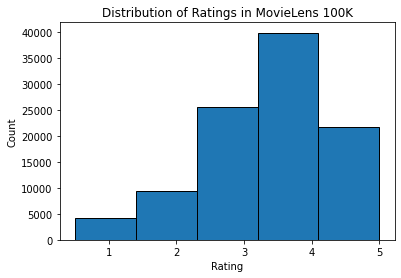

In [9]:
plt.hist(data['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in MovieLens 100K')
plt.show()

### Implicit Feedback 데이터로 변환

In [10]:
user_ids = data['user_id'].unique()
item_ids = data['item_id'].unique()

ratings_matrix = data.pivot(index='user_id', columns='item_id', values='rating')

implicit_df = dict()
implicit_df['user_id'] = list()
implicit_df['item_id'] = list()
implicit_df['label'] = list()
user_dict = dict()
item_dict = dict()

for u, user_id in tqdm(enumerate(user_ids)):
    user_dict[u] = user_id
    for i, item_id in enumerate(item_ids):
        if i not in item_dict:
            item_dict[i] = item_id
        implicit_df['user_id'].append(u)
        implicit_df['item_id'].append(i)
        if pd.isna(ratings_matrix.loc[user_id, item_id]):
            implicit_df['label'].append(0)
        else:
            implicit_df['label'].append(1)

implicit_df = pd.DataFrame(implicit_df)

0it [00:00, ?it/s]

## Label Encoding

In [11]:
user_le = LabelEncoder()
item_le = LabelEncoder()
implicit_df['user_id'] = user_le.fit_transform(implicit_df['user_id'].values)
implicit_df['item_id'] = item_le.fit_transform(implicit_df['item_id'].values)

## Loading the data

In [12]:
class MovieLensDataset(Dataset):
    def __init__(self, df, n_negs = 2, train=False):
        # class init
        self.df = df
        self.train = train
        self.n_negs = n_negs

        # data split
        self.user_list = self.df['user_id'].unique()
        self.new_df = pd.DataFrame()

        for user_id in self.user_list:
            self.temp_df = self.df[self.df['user_id'] == user_id]
            if self.train == True:
                self.positive_sample = self.temp_df[self.temp_df['label'] == 1].iloc[:-1]
                self.negative_sample = self.temp_df[self.temp_df['label'] == 0].sample(len(self.positive_sample) * self.n_negs, replace = False, random_state=42)
            else:
                self.positive_sample = self.temp_df[self.temp_df['label'] == 1].iloc[-1:]
                self.negative_sample = self.temp_df[self.temp_df['label'] == 0].sample(99, replace = False, random_state=42)
            self.new_df = pd.concat([self.new_df, self.positive_sample, self.negative_sample], ignore_index = True)
        self.df = self.new_df

        # dataloader getitem
        self.users = torch.tensor(self.df['user_id'].values)
        self.items = torch.tensor(self.df['item_id'].values)
        self.labels = torch.tensor(self.df['label'].values)
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        users = self.users[index]
        items = self.items[index]
        labels = self.labels[index]
        return (users, items, labels.float())

## activation_layer

In [13]:
def activation_layer(activation_name='relu'):

    if activation_name is None:
        activation = None
    elif isinstance(activation_name, str):
        if activation_name.lower() == 'sigmoid':
            activation = nn.Sigmoid()
        elif activation_name.lower() == 'tanh':
            activation = nn.Tanh()
        elif activation_name.lower() == 'relu':
            activation = nn.ReLU()
        elif activation_name.lower() == 'leakyrelu':
            activation = nn.LeakyReLU()
        elif activation_name.lower() == 'none':
            activation = None
    elif issubclass(activation_name, nn.Module):
        activation = activation_name()
    else:
        raise NotImplementedError("activation function {} is not implemented".format(activation_name))

    return activation

## MLPLayers

In [14]:
class MLPLayers(nn.Module):

    def __init__(self, layers, dropout, activation='relu'):
        super(MLPLayers, self).__init__()
        
        # initialize Class attributes
        self.layers = layers
        self.n_layers = len(self.layers) - 1
        self.dropout = dropout
        self.activation = activation
        
        # define layers
        mlp_modules = list()
        for i in range(self.n_layers):
            mlp_modules.append(nn.Dropout(p=self.dropout))
            input_size = self.layers[i] 
            output_size = self.layers[i + 1] 
            mlp_modules.append(nn.Linear(input_size, output_size))
            activation_function = activation_layer(self.activation)
            if activation_function is not None:
                mlp_modules.append(activation_function)

        self.mlp_layers = nn.Sequential(*mlp_modules)
        
        self._init_weights()
        
    # initialize weights
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.fill_(0.0)
    
    def forward(self, input_feature):
        return self.mlp_layers(input_feature)

## NCF Model

In [15]:
class NCF(nn.Module):

    def __init__(self, n_users, n_items, emb_dim, num_layers, dropout):
        super(NCF, self).__init__()
        
        # initialize Class attributes
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.num_layers = num_layers
        self.layers = [self.emb_dim * 2 // (2 ** i) for i in range(self.num_layers + 1)]
        self.dropout = dropout
        
        # define layers
        self.user_embedding = nn.Embedding(n_users, emb_dim) 
        self.item_embedding = nn.Embedding(n_items, emb_dim) 
        self.mlp_layers = MLPLayers(self.layers, self.dropout)
        self.predict_layer = nn.Linear(self.layers[-1] , 1) 
        self.sigmoid = nn.Sigmoid()
        
        self._init_weights()
        
    # initialize weights
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Embedding):
                normal_(m.weight, mean=0.0, std=0.01)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=1, nonlinearity="sigmoid")
                if m.bias is not None:
                    m.bias.data.fill_(0.0)


    
    def forward(self, user, item):   
        user_emb = self.user_embedding(user) 
        item_emb = self.item_embedding(item) 
        
        input_feature = torch.cat((user_emb, item_emb), -1) 
        mlp_output =  self.mlp_layers(input_feature) 
        output = self.predict_layer(mlp_output) 
        output = self.sigmoid(output)
        return output.squeeze(-1)

## GMF Model

In [16]:
class GMF(nn.Module):
    def __init__(self, num_user, num_item, emb_dim):
        super(GMF, self).__init__()
        self.user_embedding = nn.Embedding(num_user, emb_dim)
        self.item_embedding = nn.Embedding(num_item, emb_dim)
        
        self.predict_layer = nn.Linear(emb_dim, 1, bias = False)
        self.sigmoid = nn.Sigmoid()
        
        self._init_weights()
        
    # initialize weights
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Embedding):
                normal_(m.weight, mean=0.0, std=0.01)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=1, nonlinearity="sigmoid")
                if m.bias is not None:
                    m.bias.data.fill_(0.0)
    
    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        gmf = user_emb * item_emb

        output = self.predict_layer(gmf) 
        output = self.sigmoid(output)

        return output.squeeze(-1)

## Training and Evaluating the Model

In [17]:
def hit(target_item, pred_items):
    if target_item in pred_items:
        return 1
    return 0

def ndcg(target_item, pred_items):
    if target_item in pred_items:
        idx = pred_items.index(target_item)
        # 초기 인덱스가 0이기 때문에 idx + 1 -> idx + 2
        return np.reciprocal(np.log2(idx + 2))
    return 0

In [18]:
def trainer(model, dataloader, loss_fn, optm):
    model.train() # to train mode
    train_loss = 0

    for (users, items, labels) in dataloader:
        users, items, labels = users.to(device), items.to(device), labels.to(device)    

        preds = model(users, items)
        loss = loss_fn(preds, labels)

        # Update
        optm.zero_grad()      # reset gradient 
        loss.backward()      # backpropagate
        optm.step()      # optimizer update
        
        train_loss += loss.item()
    
    loss_avg = train_loss / len(dataloader)

    return loss_avg

In [19]:
def evaluator(model, dataloader, top_k):
    model.eval()
    HR, NDCG = [], []
    with torch.no_grad():
        for user, item, _ in dataloader:
            user = user.to(device)
            item = item.to(device)

            predictions = model(user, item)
            # 가장 높은 top_k개 선택
            _, indices = torch.topk(predictions, top_k)
            # 해당 상품 index 선택
            recommends = torch.take(item, indices).cpu().numpy().tolist()
            # 정답 target 선택
            target_item = item[0].item()
            HR.append(hit(target_item, recommends))
            NDCG.append(ndcg(target_item, recommends))

    return np.mean(HR), np.mean(NDCG)

In [20]:
n_negs = 2

batch_size = 256
emb_dim = 64
num_layers = 2
dropout = 0.2
num_epochs = 30
lr = 0.005
gpu_idx = 0

top_k = 30

n_users = implicit_df.user_id.max() + 1
n_items = implicit_df.item_id.max() + 1

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")

In [21]:
train_dataset = MovieLensDataset(df=implicit_df, n_negs=n_negs, train=True)
test_dataset = MovieLensDataset(df=implicit_df, n_negs=n_negs, train=False)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True) 
test_dataloader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=False, drop_last=True)

## NCF + GMF Train

In [22]:
ncf = NCF(n_users, n_items, emb_dim, num_layers, dropout).to(device)
ncf_optm = optim.Adam(ncf.parameters(), lr=lr, amsgrad=True)

gmf = GMF(n_users, n_items, emb_dim).to(device)
gmf_optm = optim.Adam(gmf.parameters(), lr=lr, amsgrad=True)

loss = nn.BCELoss().to(device)

In [23]:
gmf_losses = []
gmf_hr_list = []
gmf_ndcg_list = []
ncf_losses = []
ncf_hr_list = []
ncf_ndcg_list = []

gmf_min_loss = float("inf")
ncf_min_loss = float("inf")

for epoch in tqdm(range(num_epochs)):

    ncf_loss = trainer(ncf, train_dataloader, loss, ncf_optm)
    ncf_hr, ncf_ndcg = evaluator(ncf, test_dataloader, top_k)

    ncf_losses.append(ncf_loss)
    ncf_hr_list.append(ncf_hr)
    ncf_ndcg_list.append(ncf_ndcg)

    gmf_loss = trainer(gmf, train_dataloader, loss, gmf_optm)
    gmf_hr, gmf_ndcg = evaluator(gmf, test_dataloader, top_k)

    gmf_losses.append(gmf_loss)
    gmf_hr_list.append(gmf_hr)
    gmf_ndcg_list.append(gmf_ndcg)

    print(f'epoch: {epoch + 1}, NCF Loss: {ncf_loss:.4f}, GMF Loss: {gmf_loss:.4f}, NCF HR: {ncf_hr:.4f}, GMF HR: {gmf_hr:.4f}, NCF NDCG: {ncf_ndcg:.4f}, GMF NDCG: {gmf_ndcg:.4f}')

    if ncf_min_loss > ncf_loss:
        ncf_min_loss = ncf_loss
        torch.save(ncf.state_dict(), os.path.join(model_dir, 'NCF.pt'))

    if gmf_min_loss > gmf_loss:
        gmf_min_loss = gmf_loss
        torch.save(gmf.state_dict(),  os.path.join(model_dir, 'GMF.pt'))

  0%|          | 0/30 [00:00<?, ?it/s]

epoch: 1, NCF Loss: 0.4394, GMF Loss: 0.4618, NCF HR: 0.3705, GMF HR: 0.4705, NCF NDCG: 0.1381, GMF NDCG: 0.1946
epoch: 2, NCF Loss: 0.3964, GMF Loss: 0.2442, NCF HR: 0.3820, GMF HR: 0.5951, NCF NDCG: 0.1481, GMF NDCG: 0.3108
epoch: 3, NCF Loss: 0.3808, GMF Loss: 0.0653, NCF HR: 0.3869, GMF HR: 0.6344, NCF NDCG: 0.1611, GMF NDCG: 0.3574
epoch: 4, NCF Loss: 0.3575, GMF Loss: 0.0163, NCF HR: 0.4279, GMF HR: 0.6311, NCF NDCG: 0.1991, GMF NDCG: 0.3725
epoch: 5, NCF Loss: 0.3307, GMF Loss: 0.0041, NCF HR: 0.4574, GMF HR: 0.6328, NCF NDCG: 0.2134, GMF NDCG: 0.3817
epoch: 6, NCF Loss: 0.3106, GMF Loss: 0.0015, NCF HR: 0.4721, GMF HR: 0.6344, NCF NDCG: 0.2287, GMF NDCG: 0.3860
epoch: 7, NCF Loss: 0.2963, GMF Loss: 0.0009, NCF HR: 0.4721, GMF HR: 0.6328, NCF NDCG: 0.2242, GMF NDCG: 0.3916
epoch: 8, NCF Loss: 0.2852, GMF Loss: 0.0007, NCF HR: 0.4787, GMF HR: 0.6311, NCF NDCG: 0.2285, GMF NDCG: 0.3931
epoch: 9, NCF Loss: 0.2757, GMF Loss: 0.0006, NCF HR: 0.4951, GMF HR: 0.6311, NCF NDCG: 0.2407, 

## NCF + GMF plot

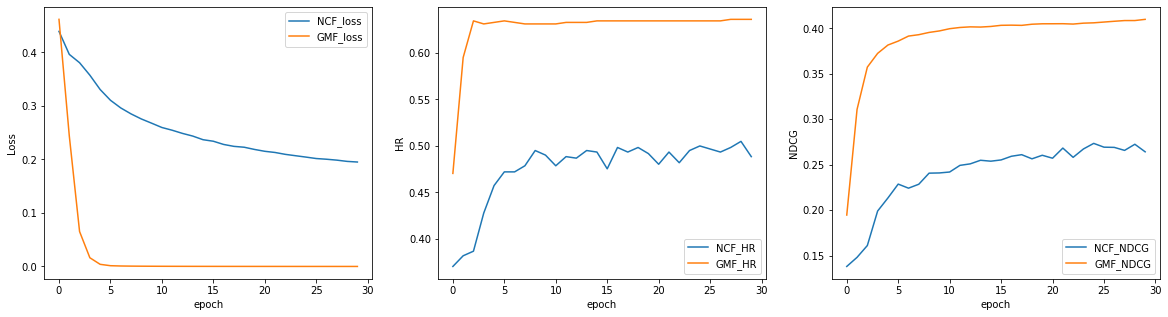

In [24]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.plot(ncf_losses,label="NCF_loss")
plt.plot(gmf_losses,label="GMF_loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(ncf_hr_list,label="NCF_HR")
plt.plot(gmf_hr_list,label="GMF_HR")
plt.xlabel("epoch")
plt.ylabel("HR")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(ncf_ndcg_list,label="NCF_NDCG")
plt.plot(gmf_ndcg_list,label="GMF_NDCG")
plt.xlabel("epoch")
plt.ylabel("NDCG")
plt.legend()

plt.show()

## NeuMF

In [29]:
class NeuMF(nn.Module):

    def __init__(self, NCF, GMF):
        super(NeuMF, self).__init__()
        
        # initialize Class attributes
        self.NCF = NCF
        self.GMF = GMF
        
        # predict_layer input 
        self.NCF_predict_input = self.NCF.predict_layer.weight.shape[1]
        self.GMF_predict_input = self.GMF.predict_layer.weight.shape[1]
        self.predict_input = self.NCF_predict_input + self.GMF_predict_input

        # define layers
        self.GMF_user_embedding = self.GMF.user_embedding
        self.GMF_item_embedding = self.GMF.item_embedding
        self.NCF_user_embedding = self.NCF.user_embedding
        self.NCF_item_embedding = self.NCF.item_embedding  
        self.mlp_layers = self.NCF.mlp_layers
        self.predict_layer = nn.Linear(self.predict_input, 1) 
        self.sigmoid = nn.Sigmoid()
        
        self._init_weights()
        
    # initialize weights
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=1, nonlinearity="sigmoid")
                if m.bias is not None:
                    m.bias.data.fill_(0.0)
    
    def forward(self, user, item):   
        GMF_user_emb = self.GMF_user_embedding(user) 
        GMF_item_emb = self.GMF_item_embedding(item)
        gmf = GMF_user_emb * GMF_item_emb

        NCF_user_emb = self.NCF_user_embedding(user) 
        NCF_item_emb = self.NCF_item_embedding(item)
        
        NCF_input_feature = torch.cat((NCF_user_emb, NCF_item_emb), -1) 
        ncf_output = self.mlp_layers(NCF_input_feature)
        gmf_ncf_concat = torch.cat((gmf, ncf_output), -1) 

        output = self.predict_layer(gmf_ncf_concat) 
        output = self.sigmoid(output)
        return output.squeeze(-1)

In [26]:
### NCF, GMF pretrained model load

ncf = NCF(n_users, n_items, emb_dim, num_layers, dropout).to(device)
ncf.load_state_dict(torch.load(os.path.join(model_dir, 'NCF.pt')))

gmf = GMF(n_users, n_items, emb_dim).to(device)
gmf.load_state_dict(torch.load(os.path.join(model_dir, 'GMF.pt')))

<All keys matched successfully>

In [30]:
# NeuMF model load
nmf = NeuMF(NCF = ncf, GMF = gmf).to(device)
nmf_optm = optim.SGD(nmf.parameters(), lr = lr, momentum = 0.9)

## NeuMF train

In [31]:
nmf_losses = []
nmf_hr_list = []
nmf_ndcg_list = []

nmf_min_loss = float("inf")

for epoch in tqdm(range(num_epochs)):

    nmf_loss = trainer(nmf, train_dataloader, loss, nmf_optm)
    nmf_hr, nmf_ndcg = evaluator(nmf, test_dataloader, top_k)

    nmf_losses.append(nmf_loss)
    nmf_hr_list.append(nmf_hr)
    nmf_ndcg_list.append(nmf_ndcg)

    print(f'epoch: {epoch + 1}, NeuMF Loss: {nmf_loss:.4f}, NeuMF HR: {nmf_hr:.4f}, NeuMF NDCG: {nmf_ndcg:.4f}')

    if nmf_min_loss > nmf_loss:
        nmf_min_loss = nmf_loss
        torch.save(nmf.state_dict(), os.path.join(model_dir, 'NeuMF.pt'))

  0%|          | 0/30 [00:00<?, ?it/s]

epoch: 1, NeuMF Loss: 0.2213, NeuMF HR: 0.5180, NeuMF NDCG: 0.2772
epoch: 2, NeuMF Loss: 0.0934, NeuMF HR: 0.5525, NeuMF NDCG: 0.3072
epoch: 3, NeuMF Loss: 0.0623, NeuMF HR: 0.5639, NeuMF NDCG: 0.3196
epoch: 4, NeuMF Loss: 0.0472, NeuMF HR: 0.5623, NeuMF NDCG: 0.3252
epoch: 5, NeuMF Loss: 0.0382, NeuMF HR: 0.5672, NeuMF NDCG: 0.3315
epoch: 6, NeuMF Loss: 0.0321, NeuMF HR: 0.5656, NeuMF NDCG: 0.3347
epoch: 7, NeuMF Loss: 0.0278, NeuMF HR: 0.5689, NeuMF NDCG: 0.3376
epoch: 8, NeuMF Loss: 0.0244, NeuMF HR: 0.5705, NeuMF NDCG: 0.3408
epoch: 9, NeuMF Loss: 0.0219, NeuMF HR: 0.5738, NeuMF NDCG: 0.3434
epoch: 10, NeuMF Loss: 0.0198, NeuMF HR: 0.5738, NeuMF NDCG: 0.3455
epoch: 11, NeuMF Loss: 0.0181, NeuMF HR: 0.5770, NeuMF NDCG: 0.3482
epoch: 12, NeuMF Loss: 0.0167, NeuMF HR: 0.5770, NeuMF NDCG: 0.3488
epoch: 13, NeuMF Loss: 0.0154, NeuMF HR: 0.5770, NeuMF NDCG: 0.3497
epoch: 14, NeuMF Loss: 0.0144, NeuMF HR: 0.5770, NeuMF NDCG: 0.3503
epoch: 15, NeuMF Loss: 0.0135, NeuMF HR: 0.5787, NeuMF ND

## NeuMF plot

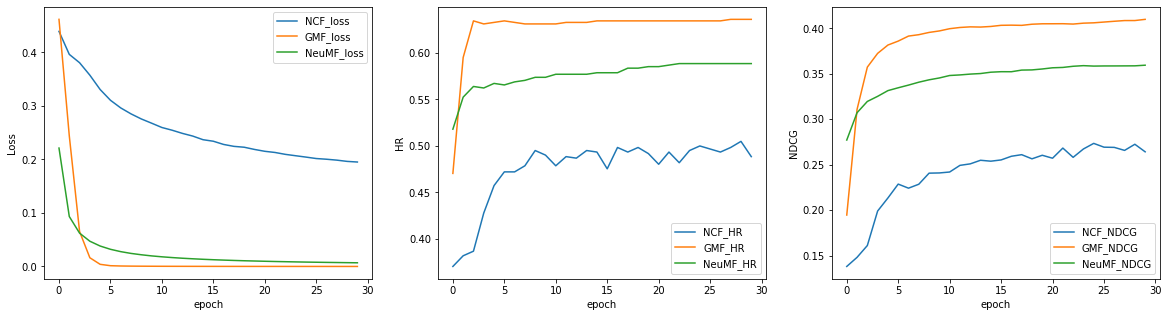

In [32]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.plot(ncf_losses,label="NCF_loss")
plt.plot(gmf_losses,label="GMF_loss")
plt.plot(nmf_losses,label="NeuMF_loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(ncf_hr_list,label="NCF_HR")
plt.plot(gmf_hr_list,label="GMF_HR")
plt.plot(nmf_hr_list,label="NeuMF_HR")
plt.xlabel("epoch")
plt.ylabel("HR")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(ncf_ndcg_list,label="NCF_NDCG")
plt.plot(gmf_ndcg_list,label="GMF_NDCG")
plt.plot(nmf_ndcg_list,label="NeuMF_NDCG")
plt.xlabel("epoch")
plt.ylabel("NDCG")
plt.legend()

plt.show()

## evaluation

In [33]:
ncf = NCF(n_users, n_items, emb_dim, num_layers, dropout).to(device)
ncf.load_state_dict(torch.load(os.path.join(model_dir, 'NCF.pt')))

gmf = GMF(n_users, n_items, emb_dim).to(device)
gmf.load_state_dict(torch.load(os.path.join(model_dir, 'GMF.pt')))

nmf = NeuMF(NCF = ncf, GMF = gmf).to(device)
nmf.load_state_dict(torch.load(os.path.join(model_dir, 'NeuMF.pt')))

ncf_hr, ncf_ndcg = evaluator(ncf, test_dataloader, top_k)
gmf_hr, gmf_ndcg = evaluator(gmf, test_dataloader, top_k)
nmf_hr, nmf_ndcg = evaluator(nmf, test_dataloader, top_k)

print(f"NeuMF HR: {nmf_hr:.4f}, NeuMF NDCG: {nmf_ndcg:.4f}, \n NCF HR: {ncf_hr:.4f}, NCF NDCG: {ncf_ndcg:.4f} \n GMF HR: {gmf_hr:.4f}, GMF NDCG: {gmf_ndcg:.4f}")

NeuMF HR: 0.5885, NeuMF NDCG: 0.3595, 
 NCF HR: 0.3230, NCF NDCG: 0.1000 
 GMF HR: 0.2934, GMF NDCG: 0.0902
